# Can the low rank approximation capture the distinct GWAS phenotypes?

Saikat Banerjee  
2023-06-05

We label the GWAS phenotypes to visualize the separation of the
principal components of the low rank approximation of the input matrix.
For low rank approximation, we use RobustPCA and Nuclear Norm
regularization, thus comparing the two methods.

# About

Here, I try to qualitatively compare the different dimensionality
reduction methods in terms of their ability to distinguish the different
traits. Suppose $\mathbf{X}$ is the $N \times P$ input matrix, with $N$
traits and $P$ associated variants. The dimensionality reduction methods
decompose the input matrix into a sparse low rank component,
$\mathbf{L}$ and a background $\mathbf{E}$, $$
\mathbf{Y} \sim \mathbf{X} + \mathbf{E}
$$ We perform PCA on the low rank matrix $\mathbf{X}$ using the SVD, $$
\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^{\intercal}
$$ Then, the principal components are given by the columns of
$\mathbf{U}\mathbf{S}$. The traits are broadly classified into NPD
phenotypes. For each “broad phenotype” $T$ and principal component $k$,
**we define the trait-wise PC score as**, $$
V_{tk} = \sum_{t \in T}(U_{tk}S_k)^2
$$ Note, the total variance explained by the component is
$\sum_{i}(U_{ik}S_k)^2 = S_k^2$.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from nnwmf.functions.frankwolfe import frank_wolfe_minimize, frank_wolfe_cv_minimize
from nnwmf.functions.robustpca import RobustPCA

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

# Data

Summary statistics data for NPD is collected from PGC, OpenGWAS and
GTEx. [See previous
work](https://banskt.github.io/npd-notes/explore/preprocess_npd_gtex_pgc_ieu.html)
for data cleaning and filtering. Our input is the Z-Score matrix for $N$
diseases and $P$ variants.

In [2]:
data_dir = "../data"
beta_df_filename   = f"{data_dir}/beta_df.pkl"
prec_df_filename   = f"{data_dir}/prec_df.pkl"
se_df_filename     = f"{data_dir}/se_df.pkl"
zscore_df_filename = f"{data_dir}/zscore_df.pkl"

'''
Data Frames for beta, precision, standard error and zscore.
'''

beta_df   = pd.read_pickle(beta_df_filename)
prec_df   = pd.read_pickle(prec_df_filename)
se_df     = pd.read_pickle(se_df_filename)
zscore_df = pd.read_pickle(zscore_df_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
select_ids = beta_df.columns

X = np.array(zscore_df.replace(np.nan, 0)[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"We have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

We have 69 samples (phenotypes) and 10068 features (variants)

We perform PCA (using SVD) on the raw input data (mean centered). In
[Figure 1](#fig-input-pca-pve), we look at the proportion of variance
explained by each principal component.

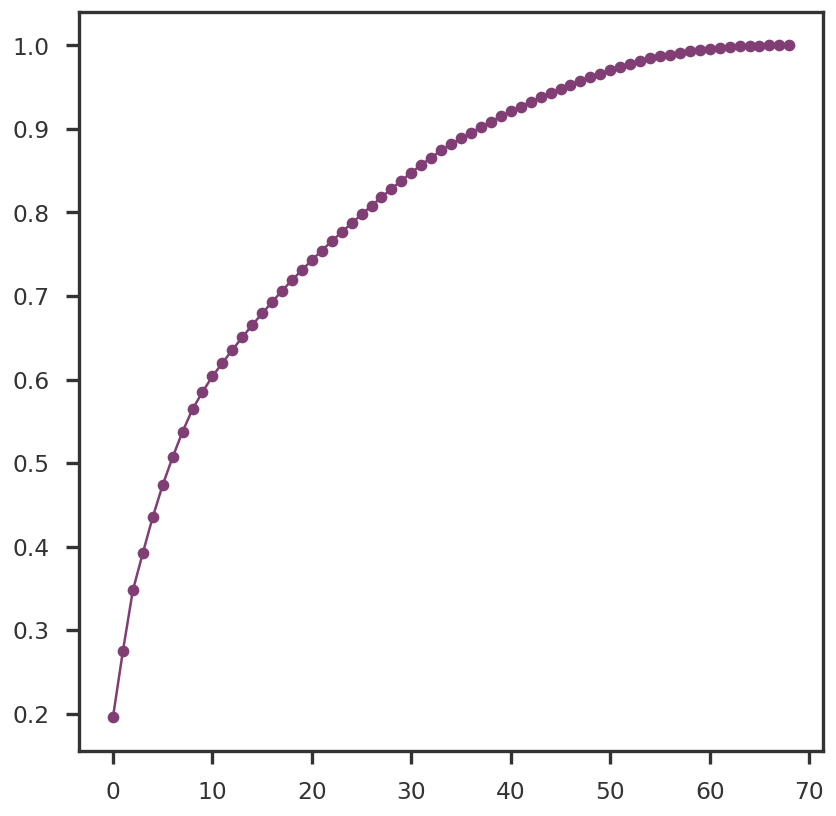

In [4]:
U, S, Vt = np.linalg.svd(Xcent, full_matrices = False)
S2 = np.square(S)
pcomp = U @ np.diag(S)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
plt.show()

# Trait-wise PC score

We break down the total variance $V_1$ explained by the first principal
component for each trait. In
[Figure 2](#fig-trait-wise-pve-pc1-input-data), we show \$V\_{t1} /
$V_1$, and note that the first component explains the variance in SZ and
BD.

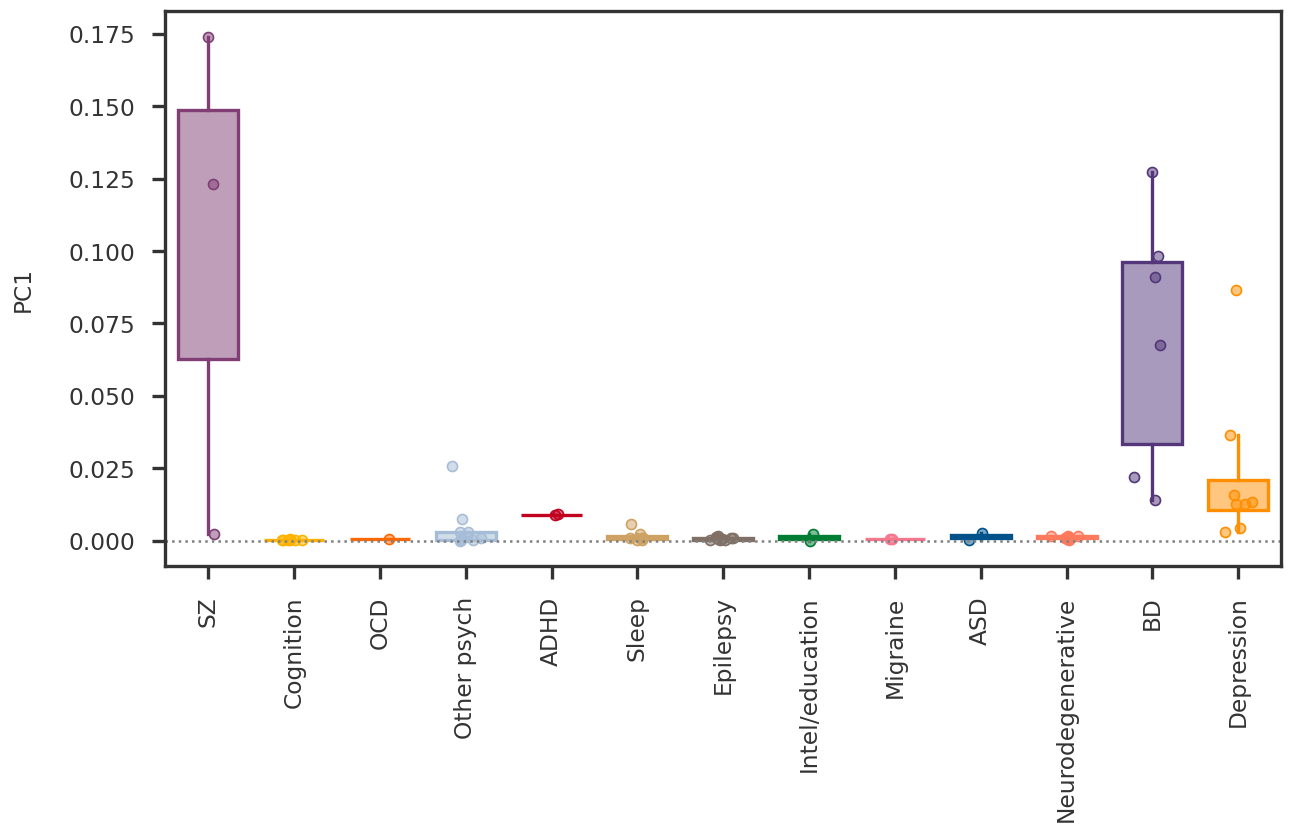

In [5]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
nsample = pcomp.shape[0]
ntrait  = len(unique_labels)



pcidx = 0
tot_variance  = np.square(S[pcidx])

trait_indices = [np.array([i for i, x in enumerate(labels) if x == label]) for label in unique_labels]
trait_pcomps  = [np.square(pcomp[idx, pcidx]) / tot_variance for idx in trait_indices]
trait_colors  = {trait: color for trait, color in zip(unique_labels, (mpl_stylesheet.kelly_colors())[:ntrait])}

def rand_jitter(n, d = 0.1):
    return np.random.randn(n) * d

for ilbl, label in enumerate(unique_labels):
    xtrait = trait_pcomps[ilbl]
    nsample = xtrait.shape[0]
    
    boxcolor = trait_colors[label]
    boxface = f'#{boxcolor[1:]}80' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
    medianprops = dict(linewidth=0, color = boxcolor)
    whiskerprops = dict(linewidth=2, color = boxcolor)
    boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
    flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
    
    ax1.boxplot(xtrait, positions = [ilbl],
                showcaps = False, showfliers = False,
                widths = 0.7, patch_artist = True, notch = False,
                flierprops = flierprops, boxprops = boxprops,
                medianprops = medianprops, whiskerprops = whiskerprops)
    
    ax1.scatter(ilbl + rand_jitter(nsample), xtrait, edgecolor = boxcolor, facecolor = boxface, linewidths = 1)


ax1.axhline(y = 0, ls = 'dotted', color = 'grey')
ax1.set_xticks(np.arange(len(unique_labels)))
ax1.set_xticklabels(unique_labels, rotation = 90)
ax1.set_ylabel(f"PC{pcidx + 1:d}")

plt.show()

In [6]:
def plot_traitwise_pc_scores(ax, U, S, unique_labels, trait_colors, min_idx = 0, max_idx = 20, alpha = 0.6,
                             use_proportion = True):
    trait_pcomps_all = dict()
    pcindices = np.arange(min_idx, max_idx)
    pcomp = U @ np.diag(S)

    for pcidx in pcindices:
        tot_variance = np.square(S[pcidx])
        if use_proportion:
            trait_pcomps_all[pcidx] = [np.square(pcomp[idx, pcidx]) / tot_variance for idx in trait_indices]
        else:
            trait_pcomps_all[pcidx] = [np.square(pcomp[idx, pcidx]) for idx in trait_indices]
    
    comp_weights = {
        trait: [np.sum(trait_pcomps_all[pcidx][ilbl]) for pcidx in pcindices] for ilbl, trait in enumerate(unique_labels)
    }

    bar_width = 1.0
    bottom = np.zeros(len(pcindices))

    for trait, comp_weight in comp_weights.items():
        ax.bar(pcindices, comp_weight, bar_width, label=trait, bottom=bottom, color = trait_colors[trait], alpha = alpha)
        bottom += comp_weight

    ax.set_xticks(pcindices)
    ax.set_xticklabels([f"{i + 1}" for i in pcindices])

    for side, border in ax.spines.items():
        border.set_visible(False)

    ax.tick_params(bottom = True, top = False, left = False, right = False,
                   labelbottom = True, labeltop = False, labelleft = False, labelright = False)
    
    return

We can do the same for each principal component and show the trait-wise
PC-score for each component, as shown in the top panel of
[Figure 3](#fig-trait-wise-pca-score-input-data). In such
representation, we lose the information of the total variance by the
component, but it gives an idea of the ability of the component to
distinguish different phenotypes. In the bottom panel, we retain the
information of the total variance explained (by avoiding the scaling to
1.0) but it is difficult to see the utility of the components with lower
variance.

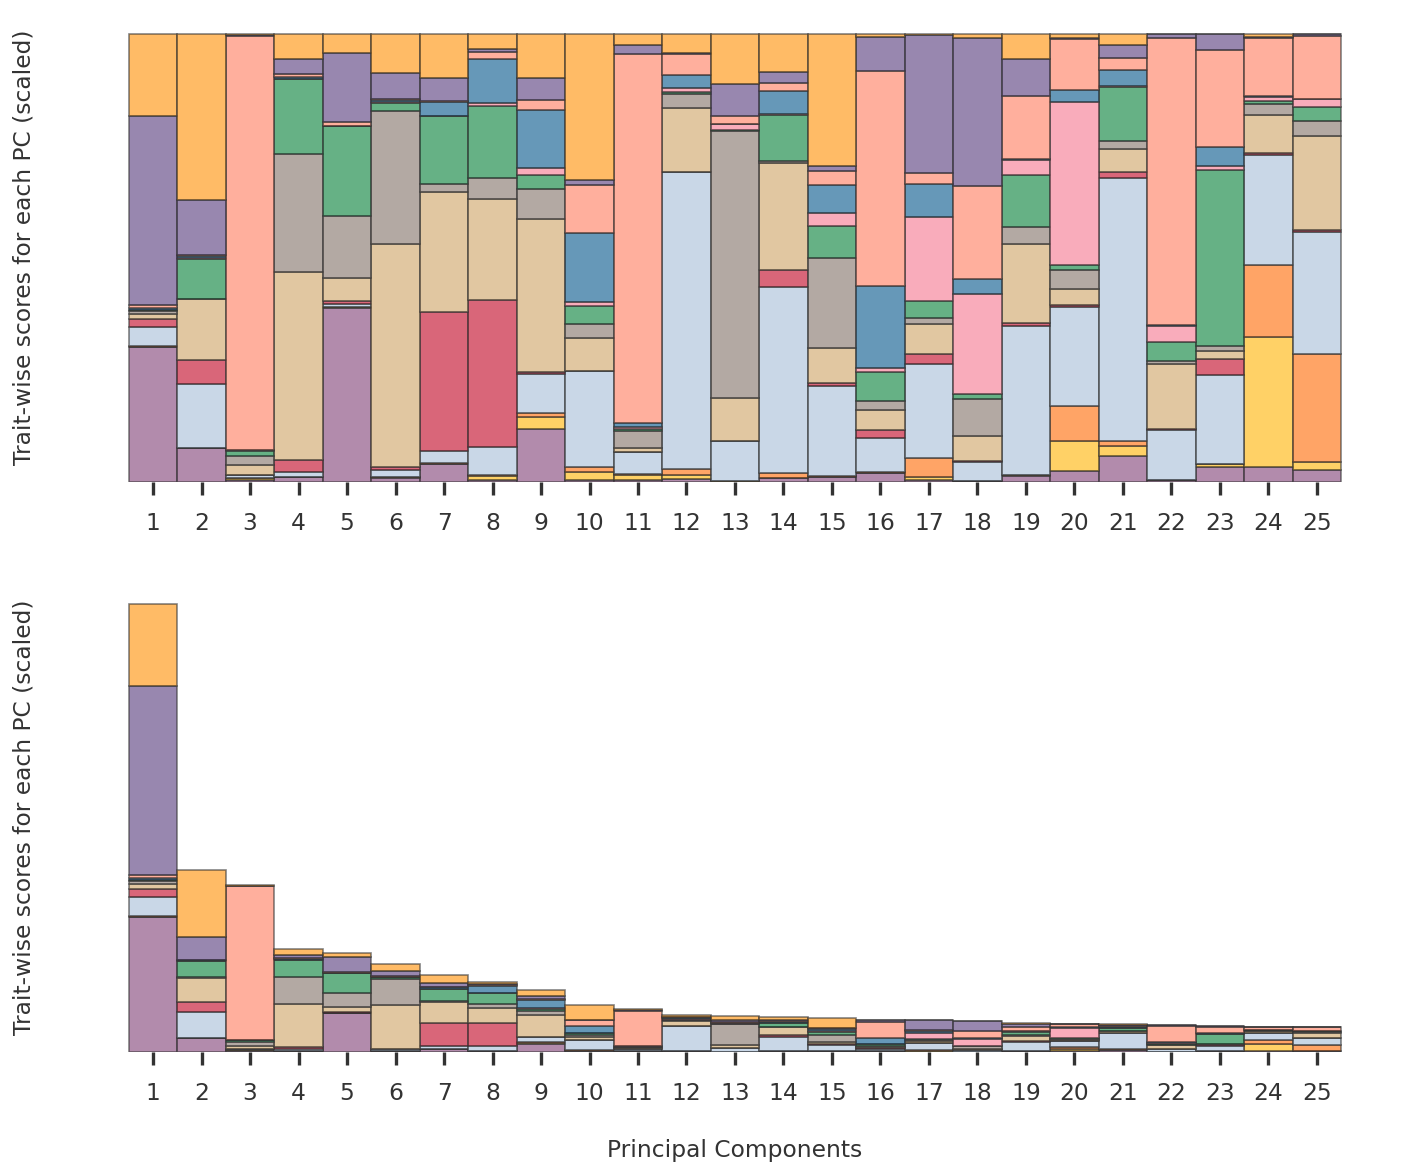

In [7]:
fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plot_traitwise_pc_scores(ax1, U, S, unique_labels, trait_colors, max_idx = 25)
plot_traitwise_pc_scores(ax2, U, S, unique_labels, trait_colors, max_idx = 25, use_proportion = False)

ax2.set_xlabel("Principal Components")
ax1.set_ylabel("Trait-wise scores for each PC (scaled)")
ax2.set_ylabel("Trait-wise scores for each PC (scaled)")
plt.tight_layout(h_pad = 2.0)
plt.show()

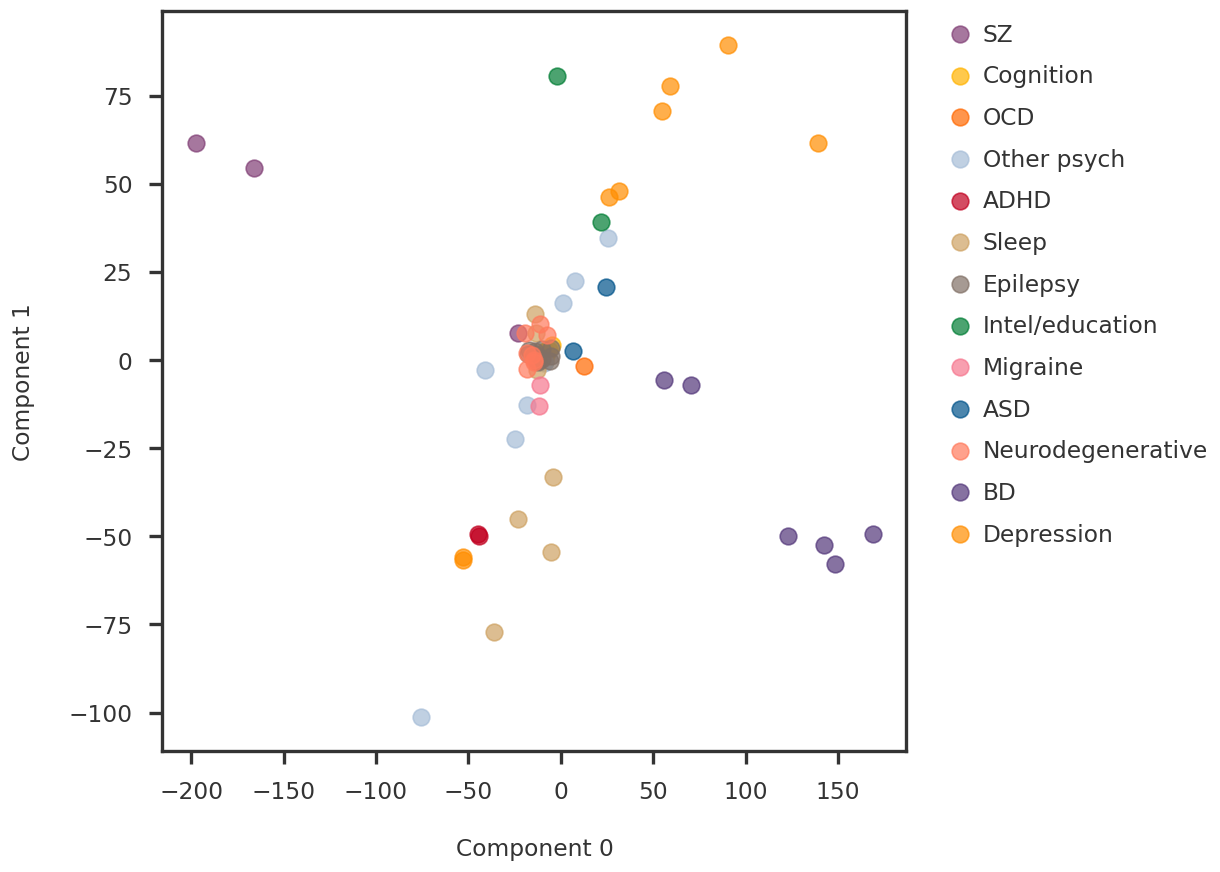

In [22]:
idx1 = 0
idx2 = 1
svd_pc1 = pcomp[:, idx1]
svd_pc2 = pcomp[:, idx2]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(svd_pc1[idx], svd_pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
plt.show()

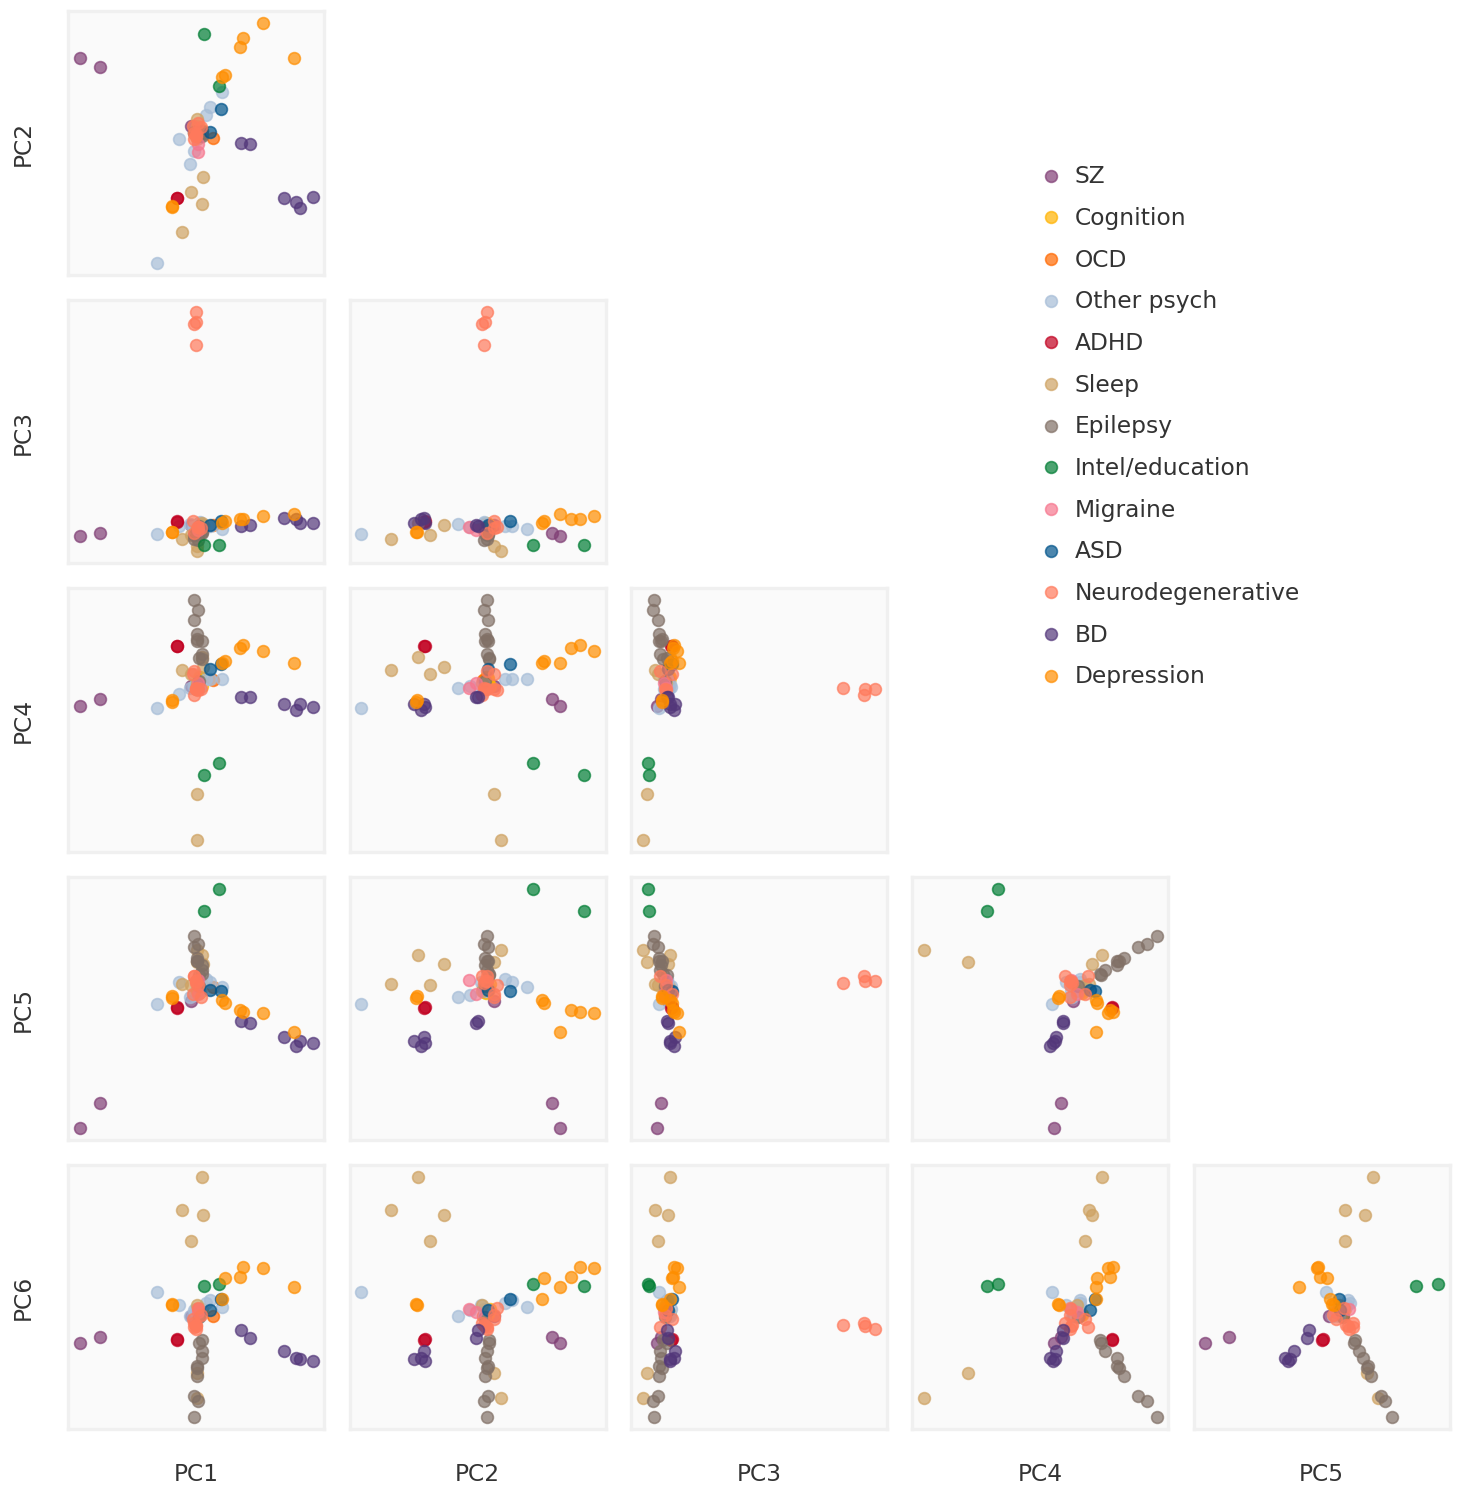

In [9]:
plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'


def make_plot_principal_components(ax, i, j, comp):
    pc1 = comp[:, j]
    pc2 = comp[:, i]
    for label in unique_labels:
        idx = np.array([k for k, x in enumerate(labels) if x == label])
        ax.scatter(pc1[idx], pc2[idx], s = 50, alpha = 0.7, label = label)
    return

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, pcomp)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()

# Experiment

Here, we perform the low-rank approximation using two methods: - Robust
PCA - Nuclear Norm Matrix Factorization using Frank-Wolfe Algorithm

In [54]:
rpca = RobustPCA(lmb=0.0095, max_iter=1000)
L_rpca, M_rpca = rpca.fit(Xcent)
np.linalg.matrix_rank(L_rpca)

24

In [21]:
r_opt = 4096.
L_cvopt, _, _ = frank_wolfe_minimize(Xcent, np.ones(Xcent.shape), r_opt)
M_cvopt = Xcent - L_cvopt

In [55]:
X_rpca = L_rpca + M_rpca

L_rpca_cent = L_rpca - np.mean(L_rpca, axis = 0, keepdims = True)
M_rpca_cent = M_rpca - np.mean(M_rpca, axis = 0, keepdims = True)
X_rpca_cent = X_rpca - np.mean(X_rpca, axis = 0, keepdims = True)

U_rpca, S_rpca, Vt_rpca = np.linalg.svd(L_rpca_cent, full_matrices = False)

L_cvopt_cent = L_cvopt - np.mean(L_cvopt, axis = 0, keepdims = True)
M_cvopt_cent = M_cvopt - np.mean(M_cvopt, axis = 0, keepdims = True)

U_cvopt, S_cvopt, Vt_cvopt = np.linalg.svd(L_cvopt_cent, full_matrices = False)

pc_cvopt = U_cvopt @ np.diag(S_cvopt)
pc_rpca  = U_rpca  @ np.diag(S_rpca)

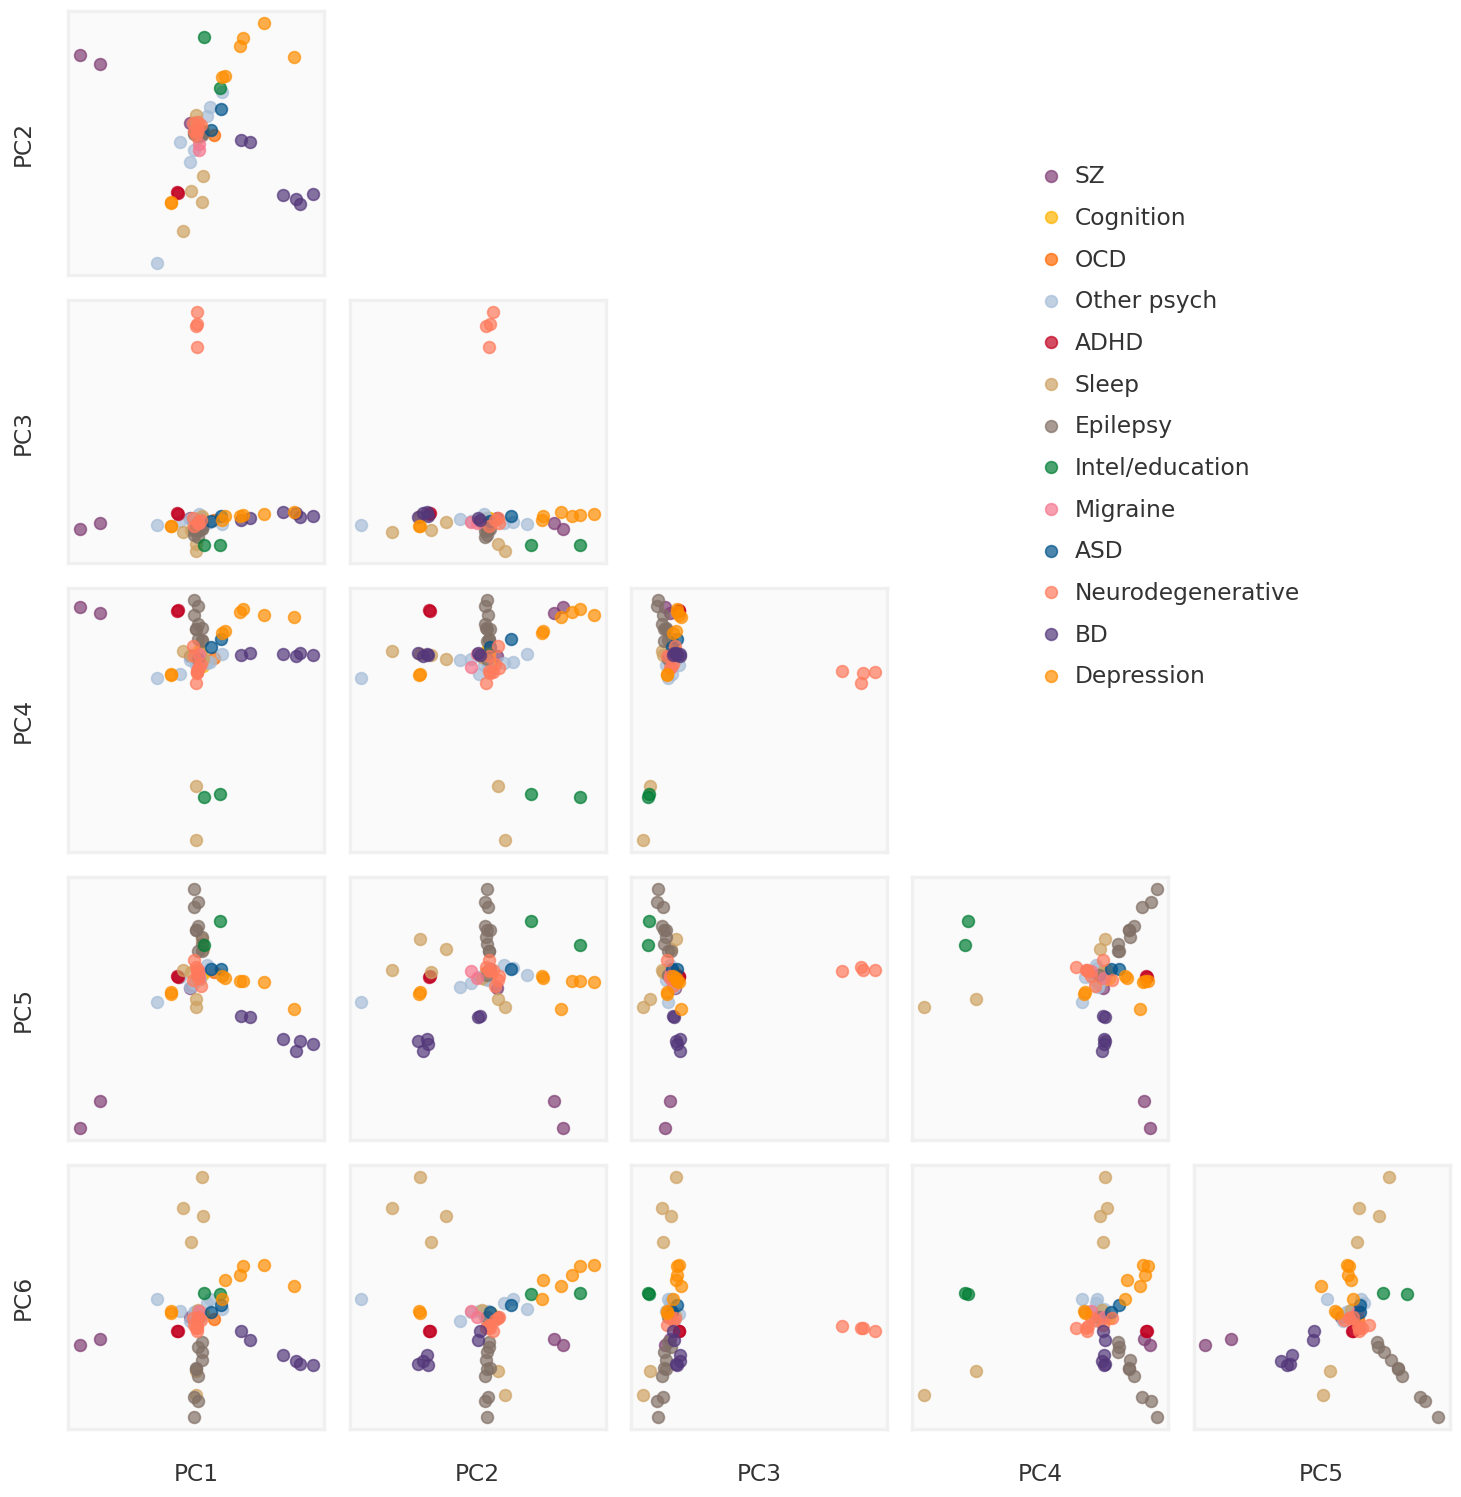

In [35]:
plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'


def make_plot_principal_components(ax, i, j, comp):
    pc1 = comp[:, j]
    pc2 = comp[:, i]
    for label in unique_labels:
        idx = np.array([k for k, x in enumerate(labels) if x == label])
        ax.scatter(pc1[idx], pc2[idx], s = 50, alpha = 0.7, label = label)
    return

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, pc_cvopt)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()

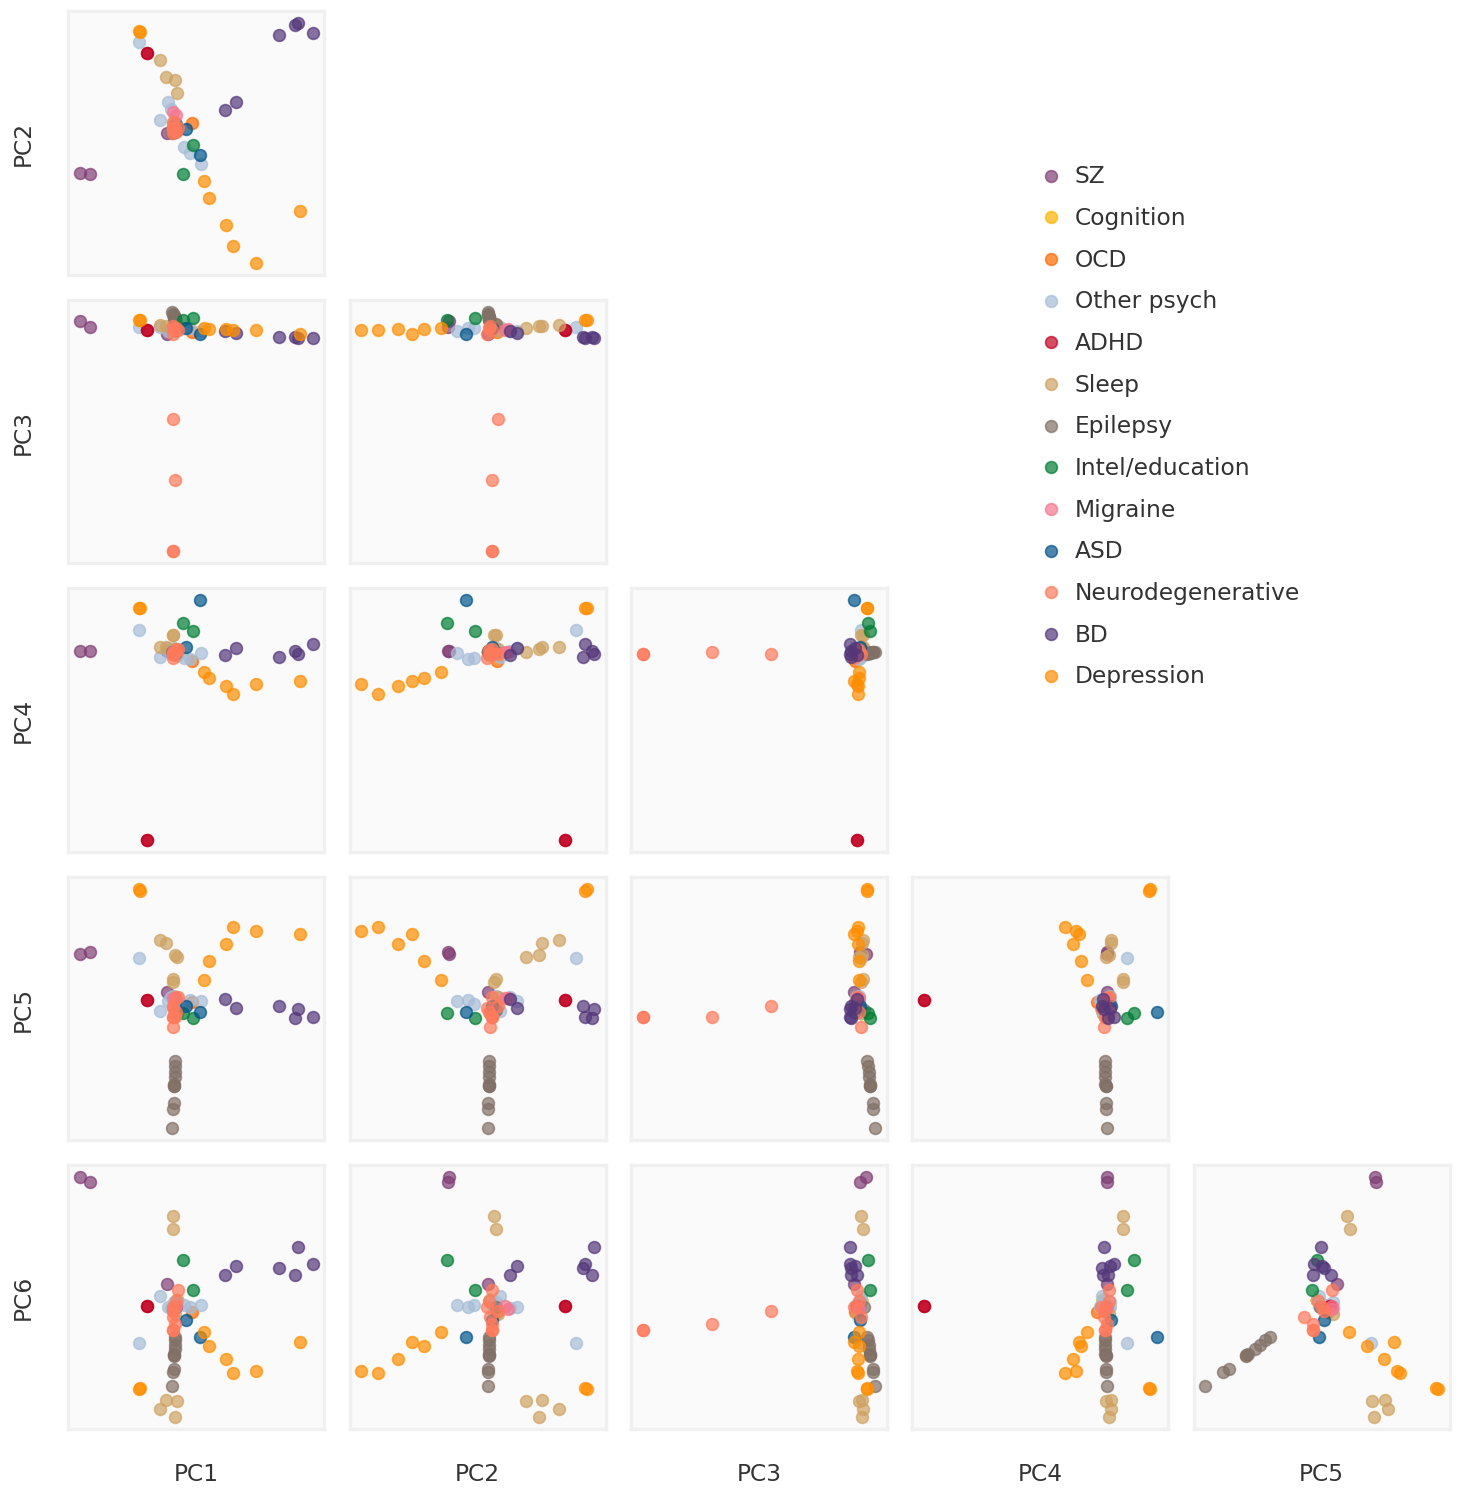

In [56]:
plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, pc_rpca)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()

In [Figure 8](#fig-trait-wise-pca-score-low-rank), we compare the
trait-wise PC scores obtained from the two methods. Note that, I am not
showing the first component because the first component is very similar
for the input data and the low-rank approximations. Neglecting the first
component also allows me to look at the unscaled component-wise PC
scores without losing too much information about the components with
lower eigenvalues.

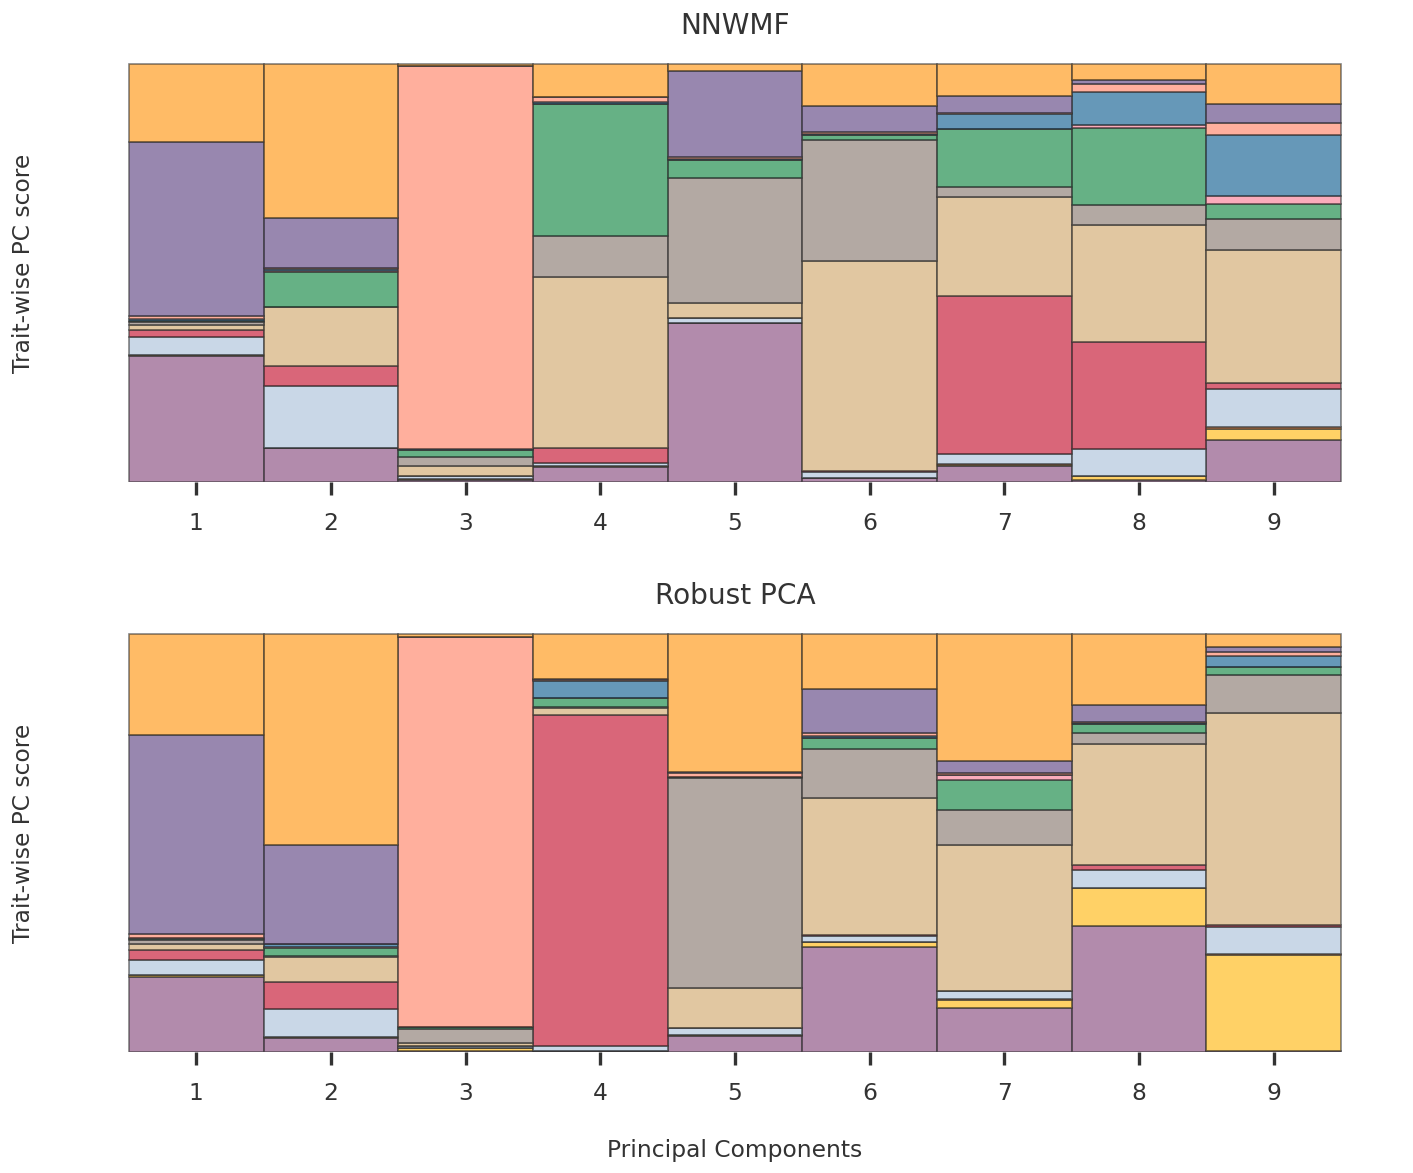

In [57]:
fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_traitwise_pc_scores(ax1, U_cvopt, S_cvopt, unique_labels, trait_colors, min_idx = 0, max_idx = 9, use_proportion = True)
#plot_traitwise_pc_scores(ax2, U_cvopt2, S_cvopt2, unique_labels, trait_colors, max_idx = 10, use_proportion = False)
plot_traitwise_pc_scores(ax2, U_rpca, S_rpca, unique_labels, trait_colors, min_idx = 0, max_idx = 9, use_proportion = True)

ax1.set_title("NNWMF")
ax2.set_title("Robust PCA")

ax2.set_xlabel("Principal Components")
ax1.set_ylabel("Trait-wise PC score")
ax2.set_ylabel("Trait-wise PC score")

plt.tight_layout(h_pad = 2.0)
plt.show()

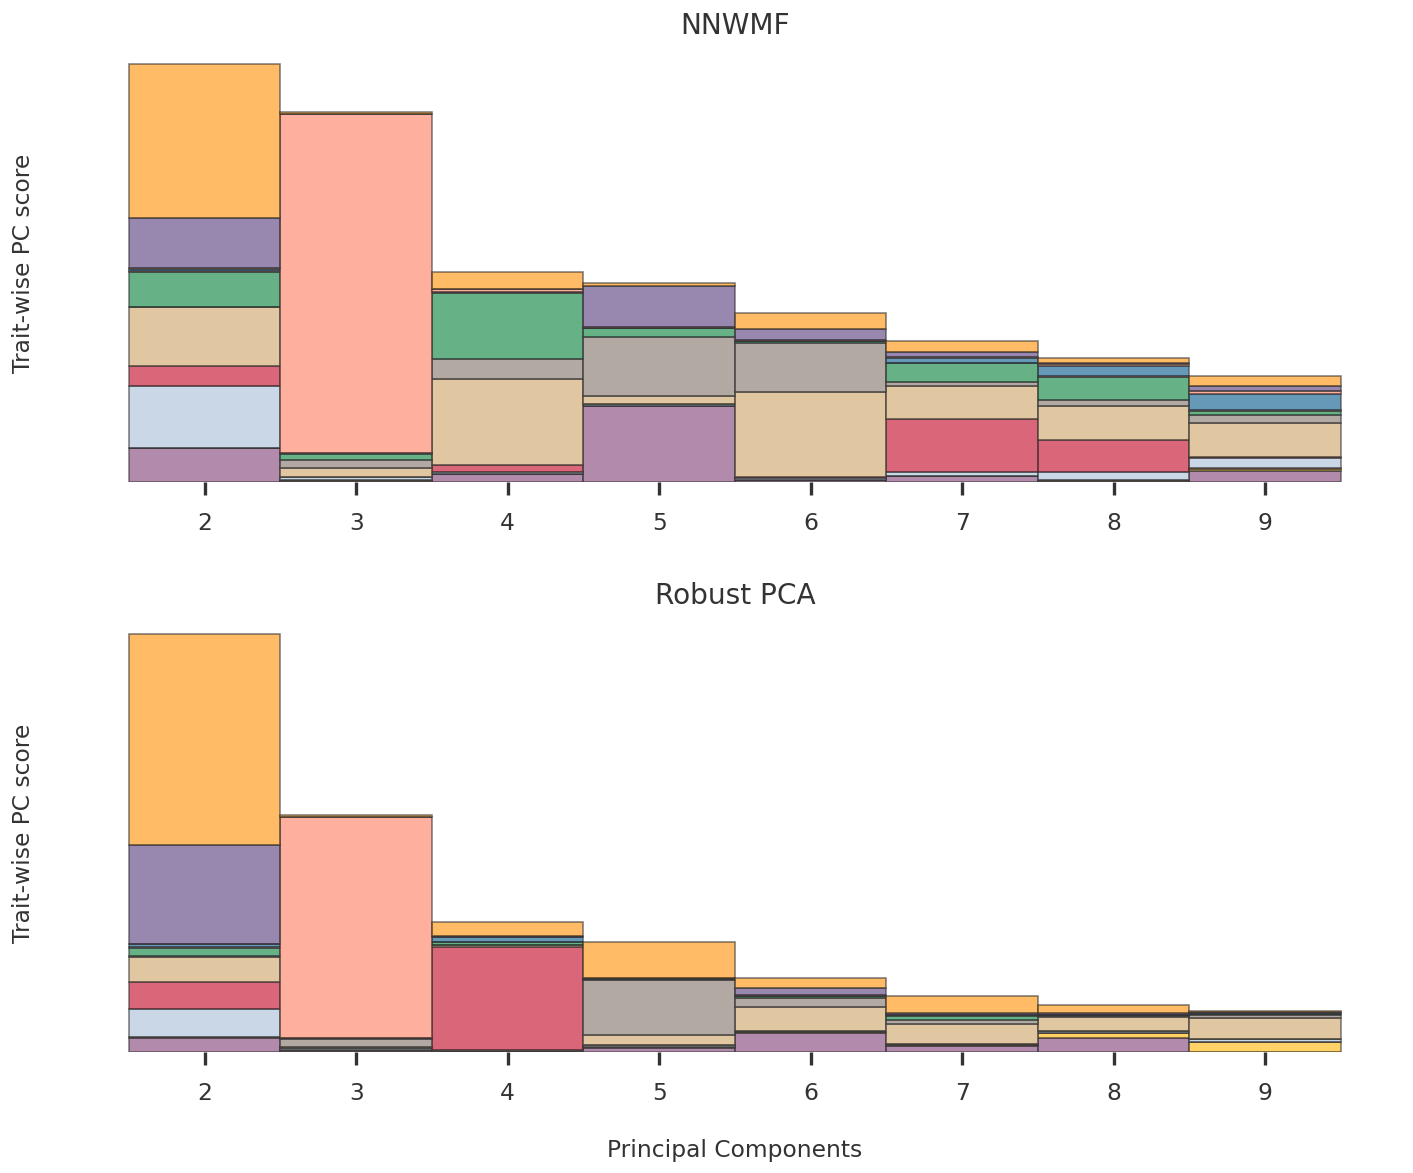

In [58]:
fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_traitwise_pc_scores(ax1, U_cvopt, S_cvopt, unique_labels, trait_colors, min_idx = 1, max_idx = 9, use_proportion = False)
#plot_traitwise_pc_scores(ax2, U_cvopt2, S_cvopt2, unique_labels, trait_colors, max_idx = 10, use_proportion = False)
plot_traitwise_pc_scores(ax2, U_rpca, S_rpca, unique_labels, trait_colors, min_idx = 1, max_idx = 9, use_proportion = False)

ax1.set_title("NNWMF")
ax2.set_title("Robust PCA")

ax2.set_xlabel("Principal Components")
ax1.set_ylabel("Trait-wise PC score")
ax2.set_ylabel("Trait-wise PC score")

plt.tight_layout(h_pad = 2.0)
plt.show()

In [39]:
np.linalg.matrix_rank(Xcent)

68

In [40]:
np.linalg.matrix_rank(L_rpca)

18

In [41]:
np.linalg.matrix_rank(L_cvopt)

66